<a href="https://colab.research.google.com/github/ComradeBlyatlov/Machine-Learning-Semantic-Segmentation/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate, Input
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping

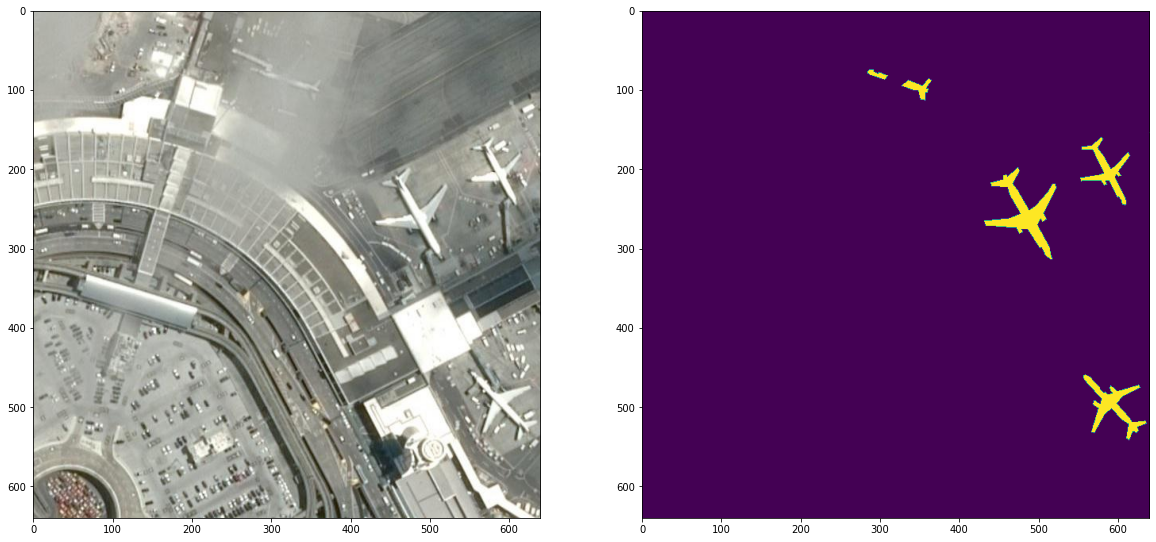

In [ ]:
path = '/content/gdrive/MyDrive/Planes/600Images/'
img = cv2.imread(path+'jpgs/007_02_1x.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path + 'pngs/007_02_1x.png', cv2.IMREAD_GRAYSCALE)
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(img)
axs[1].imshow(mask)

In [ ]:
print(img.shape)
print(mask.shape)

(640, 640, 3)
(640, 640)


In [ ]:
X = []

for filename in tqdm(sorted(os.listdir(path+ 'jpgs/'))):
  a = cv2.imread(path+'jpgs/' + filename)
  a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  a = cv2.resize(a, (128, 128))
  a = a/127
  X.append(a)

X = np.array(X)

Y = []
for filename in tqdm(sorted(os.listdir(path + 'pngs/'))):
    a = cv2.imread(path + 'pngs/' + filename, cv2.IMREAD_GRAYSCALE)
    a = cv2.resize(a, (128, 128))
    Y.append(a)
    
Y = np.array(Y)
Yc = to_categorical(Y)




A = []

for filename in tqdm(sorted(os.listdir(path+ 'tests/'))):
  a = cv2.imread(path+'tests/' + filename)
  a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  a = cv2.resize(a, (128, 128))
  a = a/127
  A.append(a)

A = np.array(A)


100%|██████████| 64/64 [00:39<00:00,  1.60it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
39


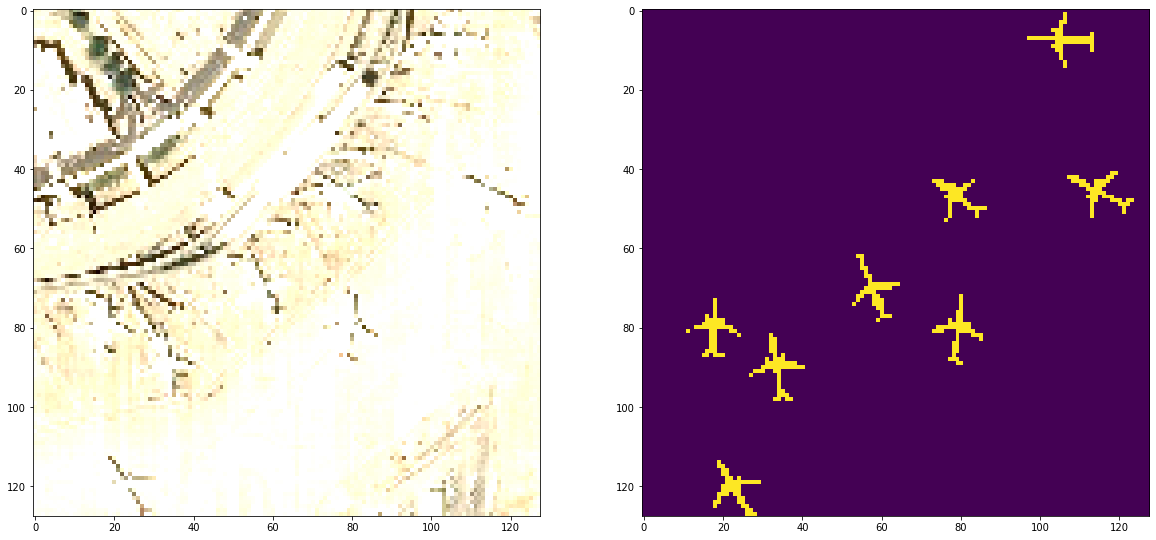

In [ ]:
print(len(X[0][0][0]))
print(len(Yc[0][0][20]))
fig,axs = plt.subplots(1,2, figsize =(20,10))
axs[0].imshow(X[-1])
axs[1].imshow(Y[-1])

In [ ]:
test_image1 = X[-1]
test_label1 = Yc[-1]
test_image2 = X[-2]
test_label2 = Yc[-2]
x_train, x_val, y_train, y_val = train_test_split(X[0:-2], Yc[0:-2], test_size = 0.1)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1438, 128, 128, 3)
(1438, 128, 128, 39)
(160, 128, 128, 3)
(160, 128, 128, 39)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


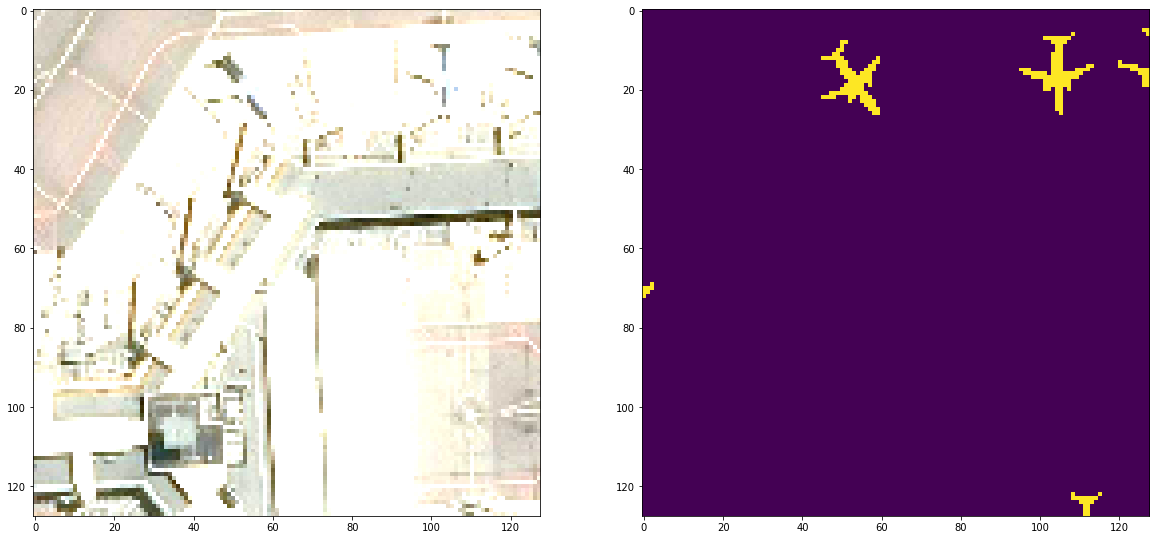

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(x_train[48])
axs[1].imshow(np.argmax(y_train[48], axis=2))

In [ ]:
def unet(num_classes = 39, image_shape = (128, 128, 3)):
    # Input
    inputs = Input(image_shape)
    # Encoder Path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv4)
    drop4 = Dropout(0.6)(conv4)
    pool4 = MaxPooling2D((2,2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv5)
    drop5 = Dropout(0.6)(conv5)
    
    # Decoder Path
    up6 = Conv2D(512, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    
    conv10 = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(conv9)
    
    model = Model(inputs, conv10)
    
    return model

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

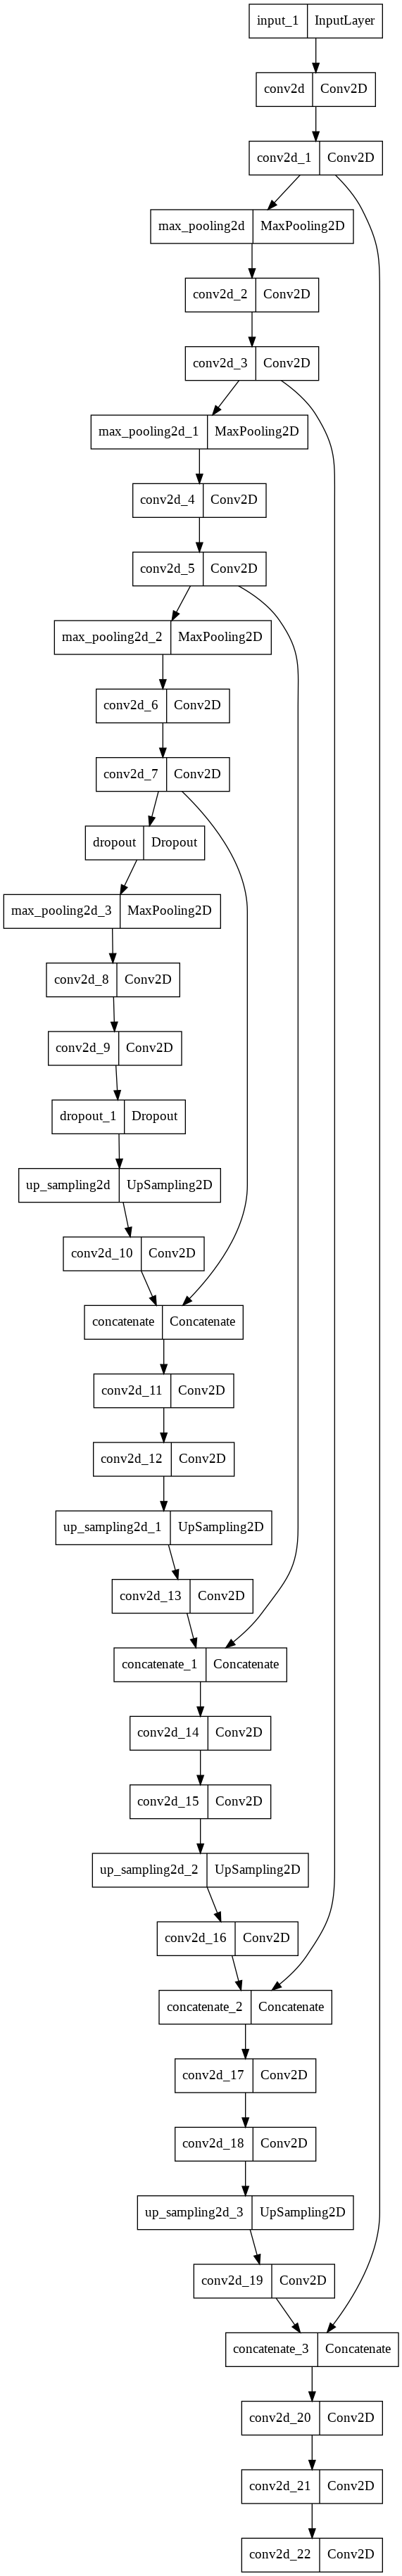

In [ ]:
plot_model(model)

In [ ]:
model_checkpoint = ModelCheckpoint('unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0, patience=60, restore_best_weights=True)

model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=16, epochs=200,
              callbacks=[model_checkpoint, model_earlyStopping])

Epoch 1/200
90/90 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9805
Epoch 1: val_loss improved from inf to 0.01655, saving model to unet_model.hdf5
90/90 [==============================] - 18s 189ms/step - loss: 0.0622 - accuracy: 0.9805 - val_loss: 0.0166 - val_accuracy: 0.9942
Epoch 2/200
90/90 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9943
Epoch 2: val_loss improved from 0.01655 to 0.01286, saving model to unet_model.hdf5
90/90 [==============================] - 17s 186ms/step - loss: 0.0161 - accuracy: 0.9943 - val_loss: 0.0129 - val_accuracy: 0.9955
Epoch 3/200
90/90 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9955
Epoch 3: val_loss improved from 0.01286 to 0.01196, saving model to unet_model.hdf5
90/90 [==============================] - 17s 187ms/step - loss: 0.0125 - accuracy: 0.9955 - val_loss: 0.0120 - val_accuracy: 0.9959
Epoch 4/200
90/90 [==============================] - ETA: 0s - loss: 0.

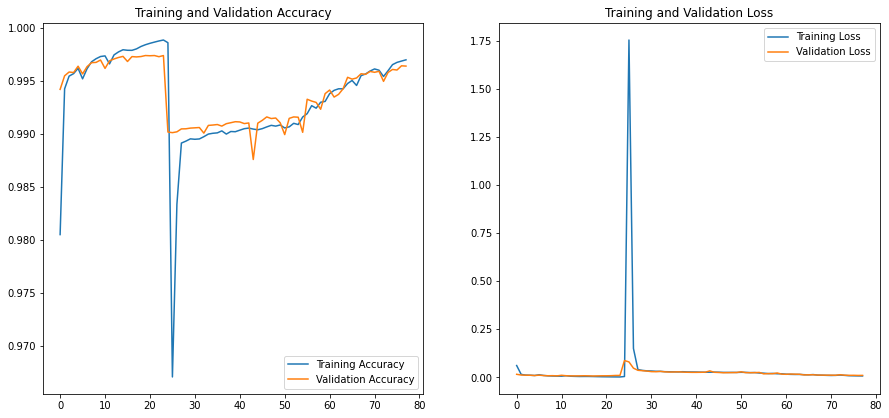

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
m1 = A[48]
pred = model.predict(np.expand_dims(m1, 0))
pred_mask = np.argmax(pred, axis=-1)
print(pred_mask.shape)
pred_mask = pred_mask[0]
print(pred_mask.shape)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(pred_mask)
axs[1].set_title('Prediction')

NameError: ignored